In [130]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from theano import shared

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [453]:
%config Inline.figure_format = 'retina'
# az.style.use('arviz-whitegrid')
az.rcParams['stats.credible_interval'] = 0.89
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['legend.fontsize']=10
plt.rcParams['axes.labelsize']=12
plt.rcParams['axes.titlesize']=12
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['figure.titlesize']=15
np.random.seed(0)

In [454]:
sns.set_palette("Set2")

## 5.1. Spuriors association

In [38]:
# Load data
data = pd.read_csv(os.path.join("/Users/huishi/Learning_DS/pymc3_resources/Rethinking_2/Data", "WaffleDivorce.csv"), delimiter=";")

Code 5.1

In [39]:
def standardize(s):
    """Standardize a pandas series"""
    return (s - s.mean())/s.std()

In [40]:
data = (data
       .assign(
           medage_std = standardize(data.MedianAgeMarriage),
           divorce_rate_std = standardize(data.Divorce),
           marriage_rate_std = standardize(data.Marriage))
       )

Code 5.2

In [41]:
data.MedianAgeMarriage.std()

1.2436303013880823

Code 5.3

In [42]:
with pm.Model() as m5_1:    
    # prior
    a = pm.Normal('a', mu=0, sigma=0.2)
    bA = pm.Normal('bA', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    # regression + likelihood
    mu = pm.Deterministic("mu", a + bA * data.medage_std)
    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sigma=sigma, observed=data.divorce_rate_std)
    
    # samples
    prior_samples = pm.sample_prior_predictive()
    m5_1_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4114.69draws/s]


Code 5.4

In [133]:
x_seq = np.linspace(-2, 2, num=50)
mu = (prior_samples['a'] + prior_samples['bA'] * x_seq.reshape(-1, 1)).T
mu.shape

(500, 50)

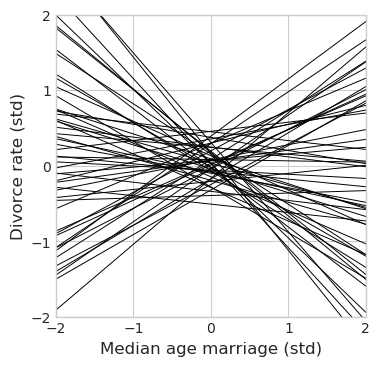

In [134]:
plt.figure(figsize=(4,4))
for i in range(50):
    plt.plot(x_seq, mu[i], 'k', linewidth=0.7)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xticks(np.arange(-2,3))
plt.yticks(np.arange(-2,3))
plt.xlabel("Median age marriage (std)")
plt.ylabel("Divorce rate (std)")
pass

Code 5.5

In [89]:
az.summary(m5_1_trace, var_names="~mu", kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.001,0.103,-0.169,0.154
bA,-0.563,0.115,-0.752,-0.398
sigma,0.825,0.087,0.684,0.955


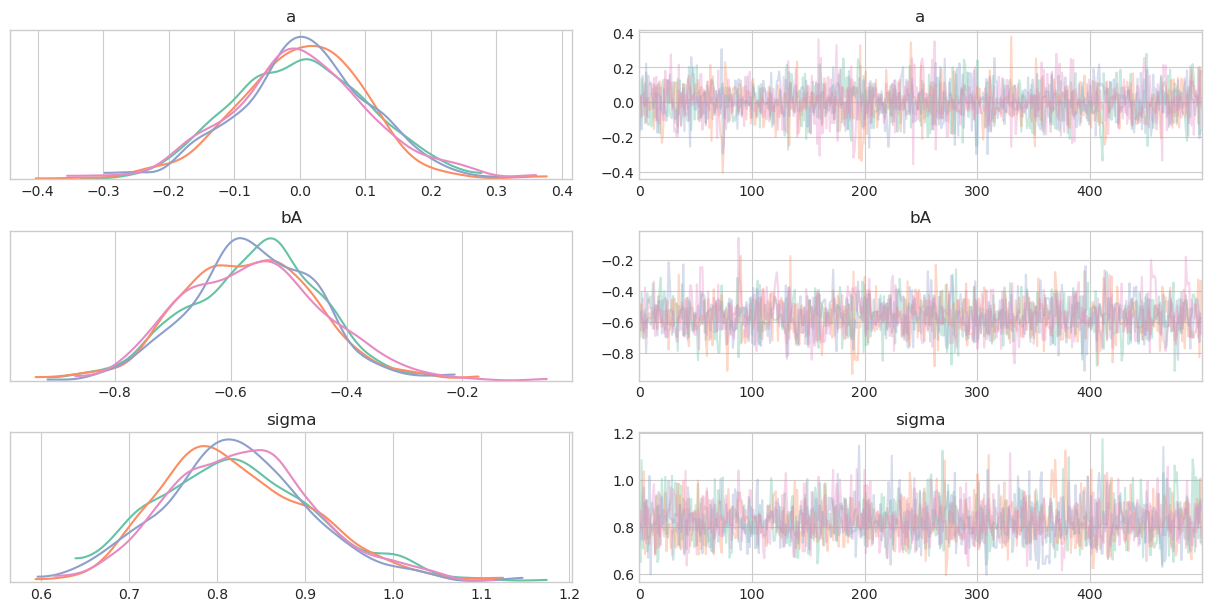

In [135]:
az.plot_trace(m5_1_trace, var_names="~mu")
pass

In [120]:
age_seq_std = np.linspace(-3, 3.2, 30)
mu = (m5_1_trace['a'] + m5_1_trace['bA'] * age_seq_std.reshape(-1, 1)).T
mu_mean = mu.mean(axis=0)
mu_hdp = az.hpd(mu)

In [170]:
# plot with std data
# plt.plot(data.medage_std, data.divorce_rate_std, "C2o", alpha=0.6)
# plt.plot(age_seq_std, mu_mean, 'k', alpha=0.5)
# az.plot_hpd(age_seq_std, mu_hdp.T)
# plt.xlabel("Median age marriage (std)")
# plt.ylabel("Divorce rate (std)")
# pass

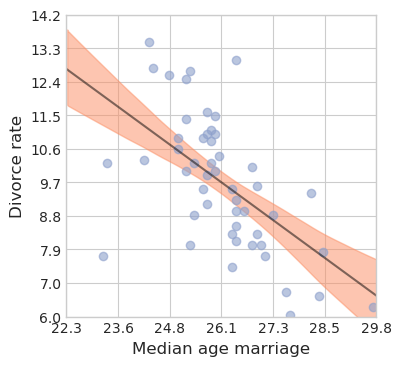

In [164]:
# plot with source data
plt.plot(data.medage_std, data.divorce_rate_std, "C2o", alpha=0.6)
plt.plot(age_seq_std, mu_mean, 'k', alpha=0.5)
az.plot_hpd(age_seq_std, mu_hdp.T)
plt.xlabel("Median age marriage")
plt.ylabel("Divorce rate")
plt.xlim(data.medage_std.min()*0.98, data.medage_std.max()*1.02)
plt.ylim(data.divorce_rate_std.min()*0.98, data.divorce_rate_std.max()*1.02)

# replace std ticks with matching orignal data
age_labels = np.round(plt.xticks()[0] * data.MedianAgeMarriage.std() + data.MedianAgeMarriage.mean(),1)
plt.xticks(ticks=plt.xticks()[0], labels=age_labels)
divorce_labels = np.round(plt.yticks()[0] * data.Divorce.std() + data.Divorce.mean(),1)
plt.yticks(ticks=plt.yticks()[0],labels=divorce_labels)
pass

Code 5.6

In [165]:
with pm.Model() as m5_2:    
    # prior
    a = pm.Normal('a', mu=0, sigma=0.2)
    bM = pm.Normal('bM', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    # regression + likelihood
    mu = pm.Deterministic("mu", a + bM * data.marriage_rate_std)
    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sigma=sigma, observed=data.divorce_rate_std)
    
    # samples
    prior_samples = pm.sample_prior_predictive()
    m5_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3889.40draws/s]


In [166]:
az.summary(m5_2_trace, var_names="~mu", kind="stats")

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.000,0.113,-0.195,0.168
bM,0.348,0.136,0.106,0.542
sigma,0.948,0.101,0.798,1.107


Code 5.10

In [333]:
with pm.Model() as m5_3:
    # prior
    a = pm.Normal('a', mu=0, sigma=0.2)
    bM = pm.Normal('bM', mu=0, sigma=0.5)
    bA = pm.Normal('bA', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    # regression + likelihood
    mu = a + bM * data.marriage_rate_std + bA * data.medage_std
    divorce_rate_std = pm.Normal('divorce_rate_std', mu=mu, sigma=sigma, observed=data.divorce_rate_std)
    
    # samples
    m5_3_trace = pm.sample() 
    ppc_m5_3 = pm.sample_posterior_predictive(m5_3_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a]
100%|██████████| 2000/2000 [00:02<00:00, 966.00it/s] 


In [172]:
az.summary(m5_3_trace, kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.000,0.103,-0.165,0.156
bM,-0.066,0.161,-0.324,0.185
bA,-0.611,0.157,-0.853,-0.356
sigma,0.827,0.083,0.684,0.943


In [184]:
az.hpd(m5_3_trace['a'])

array([-0.1645841 ,  0.15631511])

Code 5.11

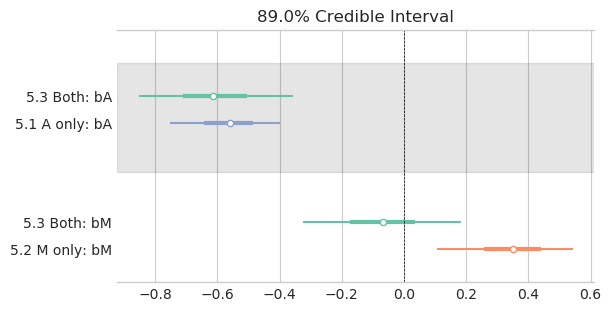

In [209]:
az.plot_forest(
    data=[m5_3_trace, m5_2_trace, m5_1_trace],
    model_names=["5.3 Both", "5.2 M only", "5.1 A only"],
    var_names=["bA", "bM"],
    combined=True, 
    figsize=(6,3),
    )
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)

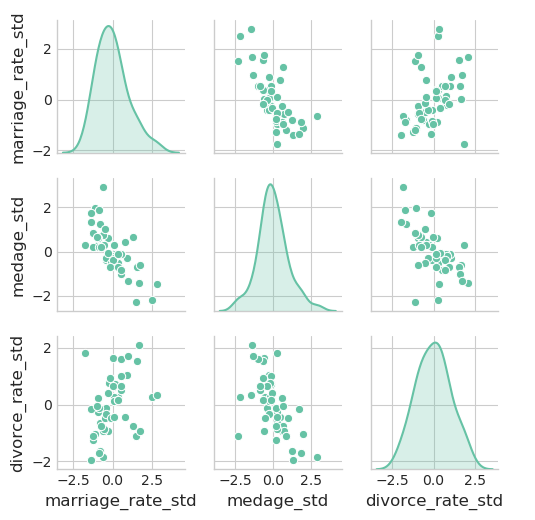

In [222]:
sns.pairplot(data, vars=['marriage_rate_std', 'medage_std', 'divorce_rate_std'], 
             height=1.7, aspect=1, diag_kind='kde')

Code 5.12

In [224]:
N = 50
age = stats.norm.rvs(size=N)
mar = stats.norm.rvs(loc=-age)
div = stats.norm.rvs(loc=age)

In [225]:
div.shape

(50,)

### 5.1.5. Plotting multivariate posterior

#### 5.1.5.1. Predictor residual plots

Code 5.13  
Use age to predict marraige rate and get residuals

In [229]:
with pm.Model() as m5_4:
    # data
    age_std = pm.Data("age_std", data.medage_std)
    marriage_std = pm.Data("marriage_std", data.marriage_rate_std)
    # prior
    a = pm.Normal("a", mu=0, sigma=0.2)
    bAM = pm.Normal("bAM", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)
    # regression + likelihood
    mu = a + bAM * age_std
    marriage_std_pred = pm.Normal("marriage_std_pred", mu=mu, sigma=sigma, observed=marriage_std)
    # posterior sampling
    trace_m5_4 = pm.sample()
    ppc_m5_4 = pm.sample_posterior_predictive(trace_m5_4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAM, a]
100%|██████████| 2000/2000 [00:18<00:00, 105.46it/s]


In [268]:
age_seq_std = np.linspace(-3, 3.2, 50)
mu_mar = (trace_m5_4['a'] + trace_m5_4['bAM'] * age_seq_std.reshape(-1,1)).T
mu_mar_mean = mu_mar.mean(axis=0)
mu_mar_hpd = az.hpd(mu_mar)

Use marriage rate residuals to predict divorce rate

In [253]:
mar_residuals = data.marriage_rate_std - ppc_m5_4['marriage_std_pred'].mean(axis=0)

with pm.Model() as m5_4_res:
    # prior
    a = pm.Normal("a", mu=0, sigma=0.2)
    bM_res = pm.Normal("bM_res", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)
    
    # regression + likelihood
    mu = a + bM_res * mar_residuals
    divorce_rate_std = pm.Normal("divorce_std_pred", mu=mu, sigma=sigma, observed=data.divorce_rate_std)
    
    # sampling
    trace_m5_4_res = pm.sample()
    ppc_m5_4_res = pm.sample_posterior_predictive(trace_m5_4_res)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM_res, a]
100%|██████████| 2000/2000 [00:01<00:00, 1028.56it/s]


In [297]:
mar_residuals.describe()

count    50.000000
mean     -0.000656
std       0.694064
min      -1.553341
25%      -0.486175
50%      -0.095399
75%       0.234711
max       1.748010
Name: marriage_rate_std, dtype: float64

In [317]:
mar_resid_seq = np.linspace(-1.8, 1.8)
mu_div = (trace_m5_4_res['a'] + trace_m5_4_res['bM_res'] * mar_resid_seq.reshape(-1, 1)).T
mu_div_mean = mu_div.mean(0)
mu_div_hdp = az.hpd(mu_div)

Create predictor residual plots Figure 5.4 on page 136.  Only the left half, where age predicts marriaga rate, then marriage rate residuals predicts divorce rate.

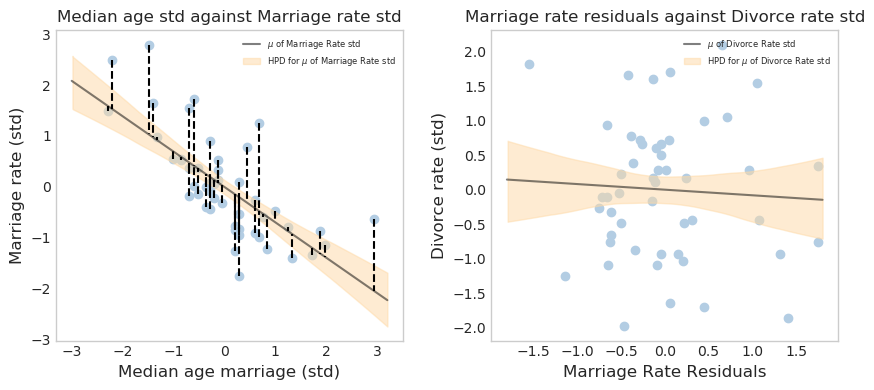

In [331]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# Plot std age to std marriage
ax1.scatter(data.medage_std, data.marriage_rate_std,  color='C1', label='')
ax1.plot(age_seq_std, mu_mar_mean, 'k', alpha=0.5, label=r"$\mu$ of Marriage Rate std")
az.plot_hpd(age_seq_std, mu_mar_hpd.T, ax=ax1, color='C4',
           fill_kwargs={"alpha":0.5, "label":r"HPD for $\mu$ of Marriage Rate std"})

mu_orig_mean = (trace_m5_4['a'] + trace_m5_4['bAM'] * np.array(data.medage_std).reshape(-1,1)).mean(axis=1)
for i in range(len(data)):
    ax1.vlines(x=data.medage_std[i], ymin=data.marriage_rate_std[i], 
               ymax=mu_orig_mean[i], linestyle='--')

ax1.set_xlabel("Median age marriage (std)")
ax1.set_ylabel("Marriage rate (std)")
ax1.set_title("Median age std against Marriage rate std")
ax1.legend(fontsize=6)
ax1.grid(False)

# Plot marriage residuals to std divorce rate
ax2.scatter(mar_residuals, data.divorce_rate_std, color='C1', label="")
ax2.plot(mar_resid_seq, mu_div_mean, 'k', alpha=0.5, label=r"$\mu$ of Divorce Rate std")
az.plot_hpd(mar_resid_seq, mu_div_hdp.T, ax=ax2, color='C4', 
           fill_kwargs={"alpha": 0.5,  "label": r"HPD for $\mu$ of Divorce Rate std"})
ax2.set_xlabel("Marriage Rate Residuals")
ax2.set_ylabel("Divorce rate (std)")
ax2.set_title("Marriage rate residuals against Divorce rate std")
ax2.legend(fontsize=6)
ax2.grid(False)

plt.tight_layout()

Code 5.14  
Is posterior predictive from pymc directly similar to constructing pp mean?

In [255]:
mar_residuals = data.marriage_rate_std - ppc_m5_4['marriage_std_pred'].mean(axis=0)

In [256]:
mu = (trace_m5_4['a'] + trace_m5_4['bAM'] * np.array(data.medage_std).reshape(-1,1)).T
mu_mean = mu.mean(axis=0)
mu_resid = data.marriage_rate_std - mu_mean

In [257]:
sum(mu_resid - mar_residuals)/len(mu_resid)

0.0027116116213759377

#### 5.1.5.2. Posterior prediction plots

Code 5.15

In [384]:
m5_3_trace.varnames

['a', 'bM', 'bA', 'sigma_log__', 'sigma']

In [385]:
mean_pred_div = ppc_m5_3['divorce_rate_std'].mean(0)
hpd_pred_div = az.hpd(ppc_m5_3['divorce_rate_std'])

div_mu = (m5_3_trace['a'] + m5_3_trace['bA'] * np.array(data.medage_std).reshape(-1, 1) + m5_3_trace['bM'] * np.array(data.marriage_rate_std).reshape(-1, 1)).T
div_mu_mean = div_mu.mean(axis=0)
div_mu_hdp = az.hpd(div_mu)

Code 5.16

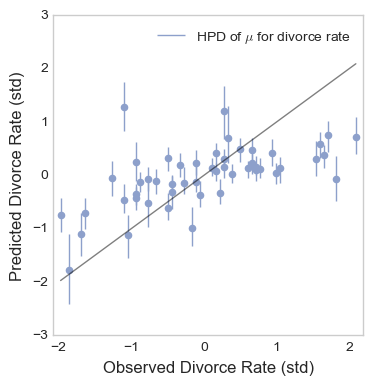

In [457]:
plt.figure(figsize=(4,4))
plt.vlines(data.divorce_rate_std, *div_mu_hdp.T, color='C2', label=r"HPD of $\mu$ for divorce rate")
plt.scatter(data.divorce_rate_std, mean_pred_div, color='C2')
min_d, max_d = data.divorce_rate_std.min(), data.divorce_rate_std.max()
plt.plot([min_d, max_d], [min_d, max_d], 'k', alpha=0.5)
plt.xlim(min_d*1.05, max_d*1.05)
plt.xlabel("Observed Divorce Rate (std)")
plt.ylabel("Predicted Divorce Rate (std)")
plt.legend()
plt.grid(False)

#### 5.1.5.3. Counterfactual plots
Code 5.19  
m5_4: A -> M  
m5_3: A -> D <- M

Code 5.20 &.21, based on Code 5.26 and 5.27

In [461]:
age_seq_std = np.linspace(-2, 2, 30)

In [ ]:
M_sim = stats.norm.rvs(loc=trace_m5_4["a"]+trace_m5_4["bAM"]*age_seq_std.reshape(-1,1), 
                       scale=trace_m5_4['sigma'])
D_sim = stats.norm.rvs(loc=m5_3_trace['a'] + m5_3_trace['bA']*age_seq_std.reshape(-1,1) + m5_3_trace['bM']*M_sim,
                      scale=m5_3_trace['sigma'])

In [486]:
M_sim.shape, D_sim.shape

((30, 2000), (30, 2000))

Code 5.22

In [491]:
az.hpd(D_sim.T).shape

(30, 2)

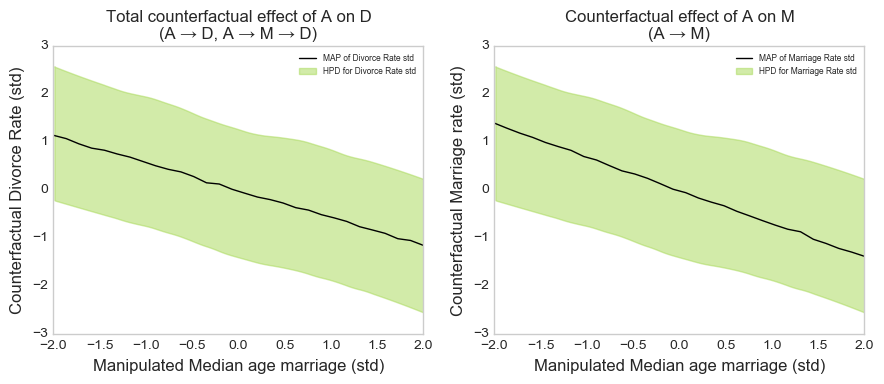

In [506]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

# total counterfactual effect A on D (A->D, A->M->D)
ax1.plot(age_seq_std, D_sim.mean(1), 'k', label=r"MAP of Divorce Rate std")
az.plot_hpd(age_seq_std, az.hpd(D_sim.T).T, ax=ax1, color='C4',
           fill_kwargs={"alpha":0.5, "label":r"HPD for Divorce Rate std"})
ax1.set_xlabel("Manipulated Median age marriage (std)")
ax1.set_ylabel("Counterfactual Divorce Rate (std)")
ax1.set_title("Total counterfactual effect of A on D\n(A → D, A → M → D)")
ax1.legend(fontsize=6)
ax1.grid(False)

# # counterfactual effect A on M (A->M)
ax2.plot(age_seq_std, M_sim.mean(1), 'k', label=r"MAP of Marriage Rate std")
az.plot_hpd(age_seq_std, az.hpd(D_sim.T).T, ax=ax2, color='C4', 
           fill_kwargs={"alpha": 0.5,  "label": r"HPD for Marriage Rate std"})
ax2.set_xlabel("Manipulated Median age marriage (std)")
ax2.set_ylabel("Counterfactual Marriage rate (std)")
ax2.set_title("Counterfactual effect of A on M\n(A → M)")
ax2.legend(fontsize=6)
ax2.grid(False)

plt.tight_layout()

**What is the expected counterfactual effect of incraseing med age from 20 to 30 on divorce rate?**

In [509]:
ages_cf_std = ([20, 30] - data.MedianAgeMarriage.mean())/data.MedianAgeMarriage.std()
mar_cf_sim = stats.norm.rvs(loc=trace_m5_4["a"]+trace_m5_4["bAM"]*ages_cf_std.reshape(-1,1), 
                       scale=trace_m5_4['sigma'])
div_cf_sim = stats.norm.rvs(loc=m5_3_trace['a'] + m5_3_trace['bA']*ages_cf_std.reshape(-1,1) + m5_3_trace['bM']*mar_cf_sim,
                      scale=m5_3_trace['sigma'])

When age increases from 20 to 30, the expected divorce rate will lower by 4.5 standard deviations. Possibly too large. Why? Because we assume likelihood is normal in regression.

In [519]:
div_cf_sim.mean(1), np.diff(div_cf_sim.mean(1))

(array([ 2.73678587, -1.80045143]), array([-4.5372373]))

Convert back to unscaled divorce rate

In [513]:
div_cf_sim.mean(1) * data.Divorce.std() + data.Divorce.mean()

array([14.67117777,  6.40971301])

**When M changes, what is the effect on D?**  
When we control for M, the arrow A -> M is deleted and A no longer influences M. Below I simulate D based on the avg state of A (A=0) and a range of controlled M values.

In [521]:
ages_cf_std = 0
mar_cf_std = np.linspace(-2, 2, 30)
div_cf_sim = stats.norm.rvs(loc=m5_3_trace['a'] + m5_3_trace['bA']*ages_cf_std + m5_3_trace['bM']*mar_cf_std.reshape(-1,1),
                      scale=m5_3_trace['sigma'])

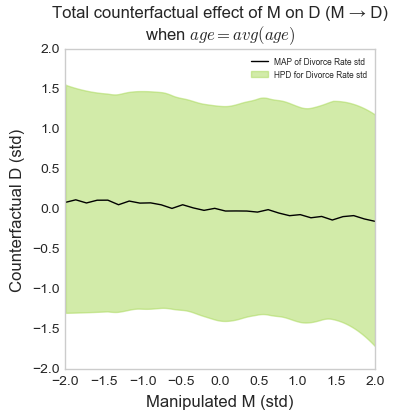

In [532]:
plt.plot(mar_cf_std, div_cf_sim.mean(1), 'k', label=r"MAP of Divorce Rate std")
az.plot_hpd(mar_cf_std, az.hpd(div_cf_sim.T).T, color='C4', 
           fill_kwargs={"alpha": 0.5,  "label": r"HPD for Divorce Rate std"})
plt.xlabel("Manipulated M (std)")
plt.ylabel("Counterfactual D (std)")
plt.title("Total counterfactual effect of M on D (M → D)\nwhen $age = avg(age)$")
plt.legend(fontsize=6)
plt.grid(False)

## 5.2. Masked Relationship

Code 5.28

In [544]:
# Load data
data = pd.read_csv(os.path.join("/Users/huishi/Learning_DS/pymc3_resources/Rethinking_2/Data", "milk.csv"), 
                   delimiter=";")
data = data.rename(mapper=lambda x: x.replace('.', '_'), axis=1)

5.29

In [548]:
data['kcal_std'] = standardize(data.kcal_per_g)
data['neo_std'] = standardize(data.neocortex_perc)
data['mass_std'] = standardize(np.log(data.mass))

5.32

In [551]:
data_clean = data[~data.isnull().any(axis=1)]

In [553]:
data_clean.shape

(17, 11)

First model with flat prior

Code 5.33

In [557]:
with pm.Model() as m5_5_draft:
    # data
    neo_std = pm.Data("neo_std", data_clean.neo_std)
    kcal_std = pm.Data("kcal_std", data_clean.kcal_std)
    
    # prior
    a = pm.Normal('a', mu=0, sigma=1)
    bN = pm.Normal('bN', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    
    # regression + likelihood
    mu = a + bN * neo_std
    pred_kcal_std = pm.Normal("pred_kcal_std", mu=mu, sigma=sigma, observed=kcal_std)
    
    # sampling
    prior_samples_m5_5_draft = pm.sample_prior_predictive()
    trace_m5_5_draft = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3306.74draws/s]
The acceptance probability does not match the target. It is 0.8801932660180417, but should be close to 0.8. Try to increase the number of tuning steps.


Code 5.34

In [567]:
neo_seq = np.array([-2, 2])
kcal_mu = prior_samples_m5_5_draft['a'] + prior_samples_m5_5_draft['bN'] * neo_seq.reshape(-1, 1)
kcal_mu.shape

(2, 500)

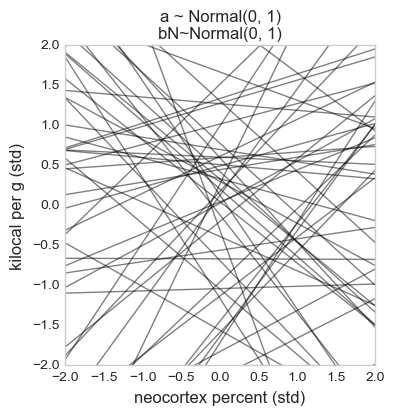

In [592]:
for i in range(50):
    plt.plot(neo_seq, kcal_mu[:, i], 'k', alpha=0.5)
plt.ylim(*neo_seq)
plt.grid(False)
plt.xlabel("neocortex percent (std)")
plt.ylabel("kilocal per g (std)")
plt.title("a ~ Normal(0, 1)\nbN~Normal(0, 1)")
pass

Code 3.35  
Tighten priors to pivot around (0,0)

In [591]:
with pm.Model() as m5_5:
    # data
    neo_std = pm.Data("neo_std", data_clean.neo_std)
    kcal_std = pm.Data("kcal_std", data_clean.kcal_std)
    
    # prior
    a = pm.Normal('a', mu=0, sigma=0.2)
    bN = pm.Normal('bN', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    # regression + likelihood
    mu = a + bN * neo_std
    pred_kcal_std = pm.Normal("pred_kcal_std", mu=mu, sigma=sigma, observed=kcal_std)
    
    # sampling
    prior_samples_m5_5 = pm.sample_prior_predictive()
    trace_m5_5 = pm.sample()
    ppc_m5_5 = pm.sample_posterior_predictive(trace_m5_5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]
100%|██████████| 2000/2000 [00:18<00:00, 110.27it/s]


Prior check

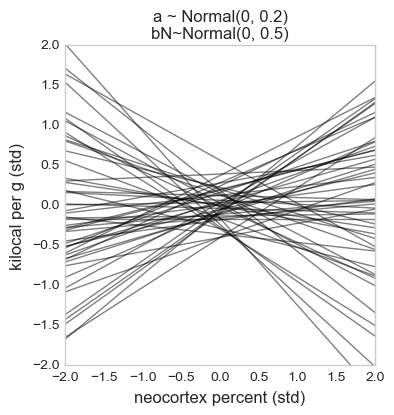

In [593]:
neo_seq = np.array([-2, 2])
kcal_mu = prior_samples_m5_5['a'] + prior_samples_m5_5['bN'] * neo_seq.reshape(-1, 1)

for i in range(50):
    plt.plot(neo_seq, kcal_mu[:, i], 'k', alpha=0.5)
plt.ylim(*neo_seq)
plt.grid(False)
plt.xlabel("neocortex percent (std)")
plt.ylabel("kilocal per g (std)")
plt.title("a ~ Normal(0, 0.2)\nbN~Normal(0, 0.5)")
pass

Code 5.36

In [596]:
az.summary(trace_m5_5, kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.043,0.164,-0.228,0.297
bN,0.128,0.231,-0.233,0.490
sigma,1.105,0.204,0.808,1.418


Code 5.37

In [597]:
neo_seq = np.linspace(data_clean.neo_std.min()-0.15, data_clean.neo_std.max()+0.15, 30)
kcal_mu = (trace_m5_5['a'] + trace_m5_5['bN'] * neo_seq.reshape(-1,1)).T
kcal_mu_mean = kcal_mu.mean(0)
kcal_mu_hpd = az.hpd(kcal_mu)

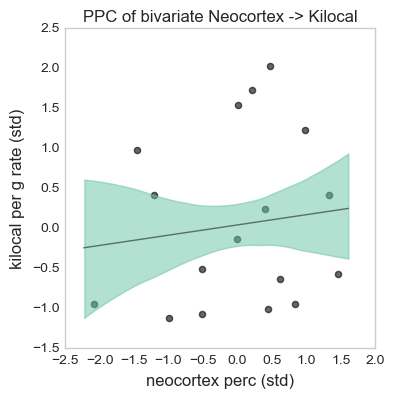

In [605]:
plt.scatter(data['neo_std'], data['kcal_std'], color='k', label="", alpha=0.6)
plt.plot(neo_seq, kcal_mu_mean, 'k', alpha=0.5)
az.plot_hpd(neo_seq, kcal_mu_hpd.T,color='C0', fill_kwargs={"alpha": 0.5})
plt.xlabel("neocortex perc (std)")
plt.ylabel("kilocal per g rate (std)")
plt.title("PPC of bivariate Neocortex -> Kilocal")
plt.grid(False)

Model body mass to kcal

In [606]:
with pm.Model() as m5_6:
    # data
    mass_std = pm.Data("mass_std", data_clean.mass_std)
    kcal_std = pm.Data("kcal_std", data_clean.kcal_std)
    
    # prior
    a = pm.Normal('a', mu=0, sigma=0.2)
    bM = pm.Normal('bM', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    # regression + likelihood
    mu = a + bM * mass_std
    pred_kcal_std = pm.Normal("pred_kcal_std", mu=mu, sigma=sigma, observed=kcal_std)
    
    # sampling
    prior_samples_m5_6 = pm.sample_prior_predictive()
    trace_m5_6 = pm.sample()
    ppc_m5_6 = pm.sample_posterior_predictive(trace_m5_6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]
100%|██████████| 2000/2000 [00:18<00:00, 107.57it/s]


In [609]:
az.summary(trace_m5_6, kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.048,0.153,-0.198,0.289
bM,-0.276,0.214,-0.638,0.058
sigma,1.058,0.191,0.746,1.313


Model body mass and neocortex to kcal

Code 3.39

In [619]:
with pm.Model() as m5_7:
    # data
    mass_std = pm.Data("mass_std", data_clean.mass_std)
    neo_std = pm.Data("neo_std", data_clean.neo_std)
    kcal_std = pm.Data("kcal_std", data_clean.kcal_std)
    
    # prior
    a = pm.Normal('a', mu=0, sigma=0.2)
    bM = pm.Normal('bM', mu=0, sigma=0.5)
    bN = pm.Normal('bN', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    # regression + likelihood
    mu = pm.Deterministic("mu", a + bM * mass_std + bN * neo_std)
    pred_kcal_std = pm.Normal("pred_kcal_std", mu=mu, sigma=sigma, observed=kcal_std)
    
    # sampling
    prior_samples_m5_7 = pm.sample_prior_predictive()
    trace_m5_7 = pm.sample()
    ppc_m5_7 = pm.sample_posterior_predictive(trace_m5_7)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, bM, a]
100%|██████████| 2000/2000 [00:18<00:00, 105.96it/s]


In [613]:
az.summary(trace_m5_7, kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.056,0.137,-0.164,0.265
bM,-0.646,0.258,-1.083,-0.270
bN,0.617,0.290,0.207,1.107
sigma,0.863,0.182,0.611,1.122


Code 4.40

array([<matplotlib.axes._subplots.AxesSubplot object at 0x14e297750>],
      dtype=object)

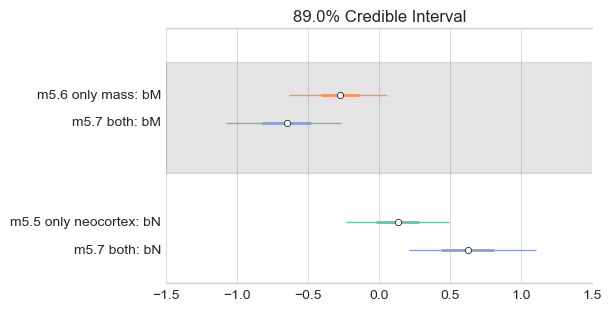

In [618]:
az.plot_forest(
    data=[trace_m5_5, trace_m5_6, trace_m5_7],
    model_names=['m5.5 only neocortex', 'm5.6 only mass', 'm5.7 both'],
    var_names = ['bM', 'bN'],
    combined=True,
    figsize=(6,3)
)

Code 5.41  
Counterfactual plots, hold mass = avg(mass)

In [631]:
ppc_m5_7['mu'].shape

(2000, 30)

100%|██████████| 2000/2000 [00:00<00:00, 2953.66it/s]


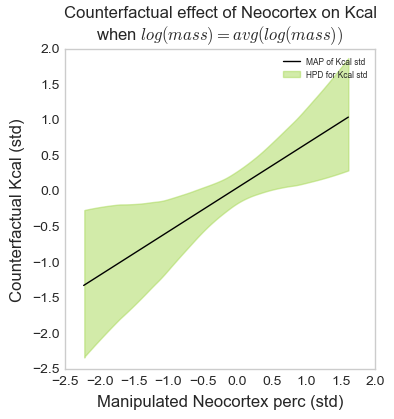

In [634]:
mass_cf = np.zeros(30)
neo_cf_seq = np.linspace(data_clean.neo_std.min()-0.15, data_clean.neo_std.max()+0.15, 30)

with m5_7:
    pm.set_data({"mass_std": mass_cf, "neo_std": neo_cf_seq})
    ppc_m5_7 = pm.sample_posterior_predictive(trace_m5_7, var_names=['mu'])

plt.plot(neo_cf_seq, ppc_m5_7['mu'].mean(0), 'k', label=r"MAP of Kcal std")
az.plot_hpd(neo_cf_seq, ppc_m5_7['mu'], color='C4', 
           fill_kwargs={"alpha": 0.5,  "label": r"HPD for Kcal std"})
plt.xlabel("Manipulated Neocortex perc (std)")
plt.ylabel("Counterfactual Kcal (std)")
plt.title("Counterfactual effect of Neocortex on Kcal\nwhen $log(mass) = avg(log(mass))$")
plt.legend(fontsize=6)
plt.grid(False)    

How to simulate data to represent DAG  
Code 5.42 & 43

In [643]:
# M -> K <- N. M -> N
size = 100
M = stats.norm.rvs(size=size)
N = stats.norm.rvs(loc=M, size=size)
K = stats.norm.rvs(loc=N-M, size=size)
data_sim1 = pd.DataFrame({"K": K, "M": M, "N": N})

# M -> K <- N. N -> M
N = stats.norm.rvs(size=size)
M = stats.norm.rvs(loc=N, size=size)
K = stats.norm.rvs(loc=N-M, size=size)
data_sim2 = pd.DataFrame({"K": K, "M": M, "N": N})

# M -> K <- N. M <- U -> N

U = stats.norm.rvs(size=size)
M = stats.norm.rvs(loc=U, size=size)
N = stats.norm.rvs(loc=U, size=size)
K = stats.norm.rvs(loc=N-M, size=size)
data_sim3 = pd.DataFrame({"K": K, "M": M, "N": N})

## 5.3. Categorical variables

### 5.3.1. Binary categories

Code 5.45

In [645]:
# Load data
data = pd.read_csv(os.path.join("/Users/huishi/Learning_DS/pymc3_resources/Rethinking_2/Data", "Howell1.csv"), 
                   delimiter=";")

In [646]:
data.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


Dummy variables assume more uncertainty for the kept categories.  
Code 5.46

In [651]:
# mu = a + b * I(x=male)
mu_female = stats.norm.rvs(178, 20, size=1000)
mu_male = stats.norm.rvs(178, 20, size=1000) + stats.norm.rvs(0, 10, size=1000)
az.summary({'mu_female': mu_female, "mu_male": mu_male}, kind="stats")

,mean,sd,hpd_5.5%,hpd_94.5%
mu_female,179.026,20.714,145.649,210.428
mu_male,178.156,22.238,142.901,212.603


Code 5.47 & 48

In [655]:
sex = data["male"].values

with pm.Model() as m5_8:
    mu = pm.Normal("mu", 178, 20, shape=2)
    sigma = pm.Uniform("sigma", 0, 50)
    height = pm.Normal("height", mu[sex], sigma, observed=data["height"])
    trace_m5_8 = pm.sample()

az.summary(trace_m5_8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2425.40draws/s]
The acceptance probability does not match the target. It is 0.8924540613602938, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],134.906,1.611,132.421,137.493,0.033,0.023,2432.0,2430.0,2453.0,1402.0,1.00
mu[1],142.585,1.689,139.861,145.201,0.034,0.024,2511.0,2511.0,2505.0,1109.0,1.01
sigma,27.430,0.850,26.051,28.701,0.018,0.012,2360.0,2337.0,2384.0,1047.0,1.01


Understand the difference in expected height

In [666]:
# estimate diff from posterior
np.mean(trace_m5_8['mu'][:, 0] - trace_m5_8['mu'][:, 1])

7.67854137316889

In [668]:
# directly create a deterministic variable in pymc model
sex = data["male"].values

with pm.Model() as m5_8:
    mu = pm.Normal("mu", 178, 20, shape=2)
    sigma = pm.Uniform("sigma", 0, 50)
    
    diff_fm = pm.Deterministic("diff", mu[0] - mu[1])
    height = pm.Normal("height", mu[sex], sigma, observed=data["height"])
    
    m5_8_trace = pm.sample()

az.summary(m5_8_trace)

INFO (theano.gof.compilelock): Refreshing lock /Users/huishi/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3721.89draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],134.898,1.607,132.291,137.378,0.030,0.021,2930.0,2930.0,2937.0,1640.0,1.0
mu[1],142.588,1.764,139.968,145.420,0.036,0.025,2393.0,2393.0,2391.0,1632.0,1.0
sigma,27.448,0.861,26.046,28.741,0.017,0.012,2682.0,2624.0,2736.0,1336.0,1.0
diff,-7.689,2.325,-11.689,-4.311,0.045,0.033,2621.0,2493.0,2635.0,1682.0,1.0


### 5.3.2. Many categories

In [670]:
# Load data
data = pd.read_csv(os.path.join("/Users/huishi/Learning_DS/pymc3_resources/Rethinking_2/Data", "milk.csv"), 
                   delimiter=";")
data = data.rename(mapper=lambda x: x.replace('.', '_'), axis=1)

In [705]:
data = data.sort_values('clade')
data['kcal_std'] = standardize(data.kcal_per_g)
data['clade_id'] = pd.Categorical(data["clade"]).codes

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3112.59draws/s]


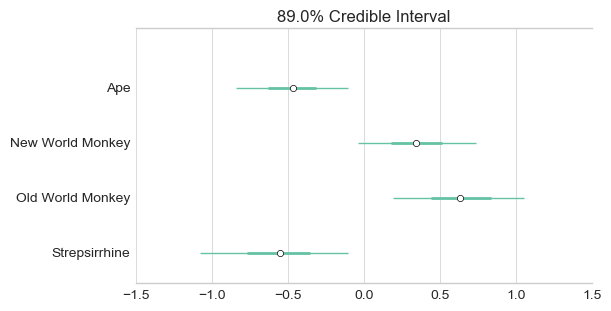

In [715]:
with pm.Model() as m5_9:
    # prior
    mu = pm.Normal('mu', 0, 0.5, shape=max(data.clade_id)+1)
    sigma = pm.Exponential("sigma", lam=1)
    # likelihood
    kcal = pm.Normal("kcal", mu=mu[data.clade_id], sigma=sigma, observed=data.kcal_std)
    # samples
    trace_m5_9 = pm.sample()
    
az.plot_forest(trace_m5_9, combined=True, var_names=["mu"], figsize=(6,3))
plt.yticks(plt.yticks()[0], labels=pd.Categorical(data['clade']).categories[::-1])
pass

Add another categorical variable to the model  
Code 5.53

In [720]:
np.random.seed(63)
data['house'] = np.random.choice(range(4), size=len(data))

In [723]:
data.clade_id.nunique()

4

In [729]:
with pm.Model() as m5_10:
    # prior
    a = pm.Normal('a', 0, 0.5, shape=data.clade_id.nunique())
    h = pm.Normal('h', 0, 0.5, shape=data.house.nunique())
    sigma = pm.Exponential("sigma", lam=1)
    
    # likelihood
    mu = a[data.clade_id] + h[data.house]
    kcal = pm.Normal('kcal', mu=mu, sigma=sigma, observed=data.kcal_std)
    
    # sample
    trace_m5_10 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, h, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1736.27draws/s]


In [732]:
az.summary(trace_m5_10, var_names=["a", "h"], kind="stats")

,mean,sd,hpd_5.5%,hpd_94.5%
a[0],-0.497,0.270,-0.929,-0.060
a[1],0.396,0.287,-0.063,0.846
a[2],0.574,0.315,0.063,1.063
a[3],-0.529,0.305,-0.994,-0.027
h[0],0.295,0.285,-0.183,0.724
h[1],0.100,0.302,-0.368,0.570
h[2],-0.148,0.273,-0.592,0.272
h[3],-0.381,0.298,-0.826,0.132


In [735]:
%reload_ext watermark
%watermark -n -u -v -iv -w

seaborn 0.10.1
pymc3   3.8
numpy   1.18.1
pandas  1.0.3
arviz   0.7.0
last updated: Sat Jun 20 2020 

CPython 3.7.6
IPython 7.14.0
watermark 2.0.2
